# [1D-BASELINE] Exp20: Tilt Robot Baseline

## Import

In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [2]:
import pickle
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
import datetime
import time
from IPython.display import clear_output

In [4]:
from grace.system import Grace
from grace.capture import LeftEyeCapture, RightEyeCapture
from grace.utils import get_center_chessboard_point, generate_triangle_wave

## Initialization

In [5]:
# Experiment Helper Functions

def px_to_deg_fx(x):
    x = math.atan(x/581.0651)  # fx = 518.0651. fy = 581.0060
    x = math.degrees(x)
    return x

def save_pickle_data(data, camera: str, name: str):
    # Making Directory
    filename = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f") + "_" + camera + "_" + name
    filepath = os.path.join(os.path.abspath(".."), "results", filename)

    # Saving to Pickle File
    with open(filepath + ".pickle", 'wb') as file:
        pickle.dump(data, file)
    print('Data saved in:', filepath + ".pickle")
    return filepath + ".pickle"

def slow_reset():
    # grace.slow_move_left_eye_pan(angle=-8, step_size=0.0879, time_interval=0.015)
    # grace.slow_centering_eyes()
    state = grace.move_left_eye((None, 0))
    return state
    
def generate_graphs(data, y_org=219.22972847):
    # tilt_idx = tilt_arr.index(tilt)
    tilt_idx = 0
    
    # Input Array
    plt.figure()
    input_arr  = data["input_arr"]
    plt.plot(input_arr)
    plt.ylim([-32, 32])
    plt.xlabel('Samples')
    plt.ylabel('Input Angle (deg)')
    plt.title('Input Motor Command')
    
    # Pixel vs Input Array (Raw)
    raw_y_pixel_arr = [x[1] for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr, raw_y_pixel_arr, color='orange')
    plt.xlabel('Input Angle (deg)')
    plt.ylabel('Pixel Y Value')
    plt.title('Raw Pixel Position')
    plt.grid()
    
    # Pixel vs Input Array (Raw)
    x_pixel_arr = [x[1]-y_org for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr, x_pixel_arr, color='orange')
    plt.xlabel('Input Angle (deg)')
    plt.ylabel('Delta Pixel Y Value (wrt 219.2297 px)')
    plt.title('Raw Pixel Position')
    plt.grid()
    
    # Time Series Eye Output vs Input Array
    phi = [px_to_deg_fx(x[1]-y_org) for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr)
    plt.plot(phi, color='orange')
    plt.xlabel('Samples')
    plt.ylabel('Angles (deg)')
    plt.ylim([-32, 32])
    plt.legend(['Input Command', 'Eye Output'])
    plt.title('Theta vs Phi')

    # Eye Output vs Input Array
    plt.figure()
    plt.plot(input_arr, phi, color="orange")
    plt.xlabel('Input Command')
    plt.ylabel('Eye Output')
    plt.title('Robot Data')
    plt.grid() 
    

In [6]:
log_cmd = [1, 2, 4, 8, 16, 30]
log_cmd_str = ['1', '2', '4', '8', '16', '30']

# Loading the Data

In [13]:
filename = "20230530_014928_625460_left_1D-BASELINE_EXP20_TiltRobotBaseline.pickle"
fn = os.path.join(os.path.abspath(".."), "const_results",filename)

In [23]:
# Opening of Pickle File

with open(fn, 'rb') as file:
    data_load = pickle.load(file)
baseline_data= data_load

## Data Analysis

In [24]:
def random_colors(n):
    return np.random.rand(n,3)

rand_colors = random_colors(len(data_load["data"]))

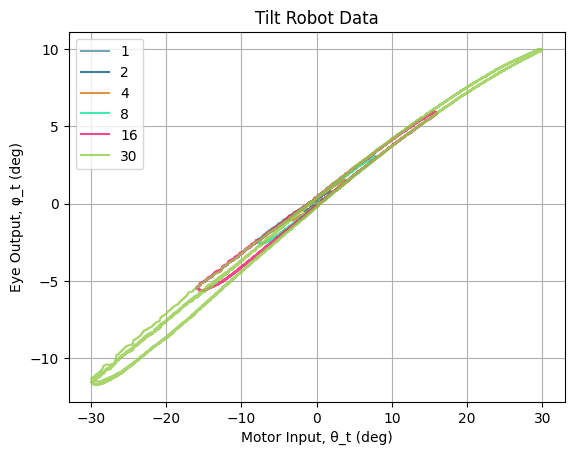

In [25]:
# Data Superposition

# Time Series Eye Output vs Input Array
y_org = 201.68845842
tilt_idx = 0

for i in range(len(data_load["data_label"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x[1]-y_org) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, color=rand_colors[i], alpha=0.8)
    
plt.xlabel('Motor Input, θ_t (deg)')
plt.ylabel('Eye Output, φ_t (deg)')
plt.title('Tilt Robot Data')
plt.grid()
plt.legend(log_cmd_str)

(-2.0, 7.0)

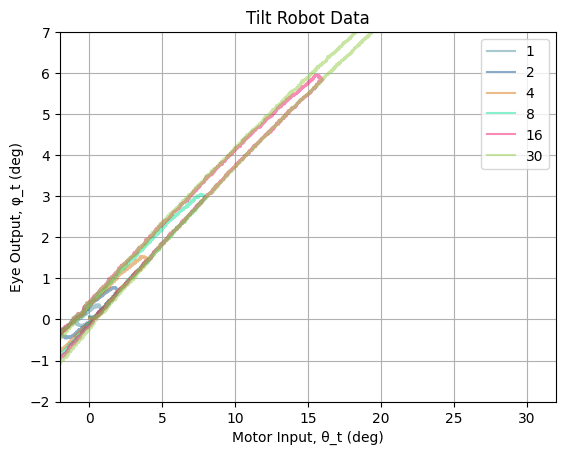

In [26]:
# Zoomed Data Superposition

# Time Series Eye Output vs Input Array
y_org = 201.68845842
tilt_idx = 0

for i in range(len(data_load["data_label"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x[1]-y_org) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, color=rand_colors[i], alpha=0.5)
    
plt.xlabel('Motor Input, θ_t (deg)')
plt.ylabel('Eye Output, φ_t (deg)')
plt.title('Tilt Robot Data')
plt.grid()
plt.legend(log_cmd_str)
plt.xlim([-2, 32])
plt.ylim([-2, 7])

(-16.0, 5.0)

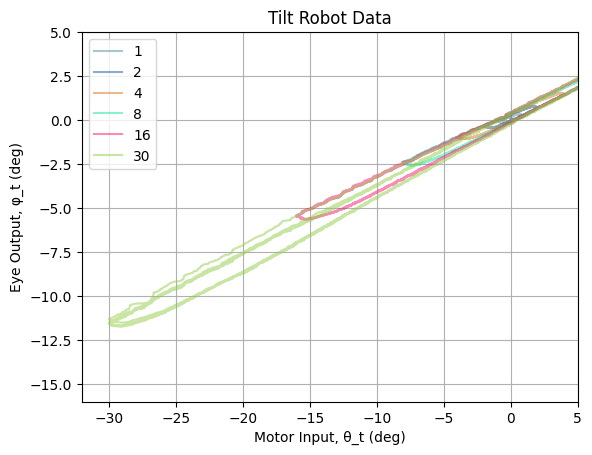

In [27]:
# Zoomed Data Superposition

# Time Series Eye Output vs Input Array
y_org = 201.68845842
tilt_idx = 0

for i in range(len(data_load["data_label"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x[1]-y_org) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, color=rand_colors[i], alpha=0.5)
    
plt.xlabel('Motor Input, θ_t (deg)')
plt.ylabel('Eye Output, φ_t (deg)')
plt.title('Tilt Robot Data')
plt.grid()
plt.legend(log_cmd_str)
plt.xlim([-32, 5])
plt.ylim([-16, 5])

# Regression

In [28]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

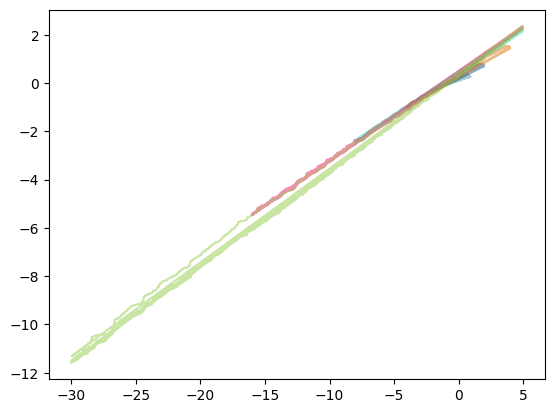

In [29]:
# Line Data Parameters

trim_list = [1, 2, 4, 8, 16, 30]
X_arr = []
Y_arr = []
for i in range(len(baseline_data["data"])):
    pos_log = -1
    input_arr = []
    phi = []
    for cnt in range(len(baseline_data["data"][i]["input_arr"])):
        if cnt > (trim_list[i]/0.0896):
            data = baseline_data["data"][i]["input_arr"][cnt]
            if data > -30 and data < 5 and (data-pos_log)<0:
                input_arr.append(data)
                temp = baseline_data["data"][i]["pixel_arr"][tilt_idx][cnt]
                phi.append(px_to_deg_fx(temp[1]-y_org))
            pos_log = data

    X_arr.extend(input_arr)
    Y_arr.extend(phi)
    
    # Eye Output vs Input Array
    plt.plot(input_arr, phi, color=rand_colors[i], alpha=0.5)
    
X = np.array(X_arr).reshape((-1,1))
Y = np.array(Y_arr)

In [35]:
# Instantiation
base_regression_model = LinearRegression(fit_intercept=True)

# Fit the data(train the model)
base_regression_model.fit(X, Y)

# Predict
y_predicted_baseline = base_regression_model.predict(X)

# Evaluation
rmse = mean_squared_error(Y, y_predicted_baseline)
r2 = r2_score(Y, y_predicted_baseline)

# Printing values
base_slope = base_regression_model.coef_[0]
print(f'Slope: {base_slope:.4f}')
print('Intercept:', base_regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: 0.3910
Intercept: 0.4017149515834979
Root mean squared error:  0.036737164665050025
R2 score:  0.9970542084571139


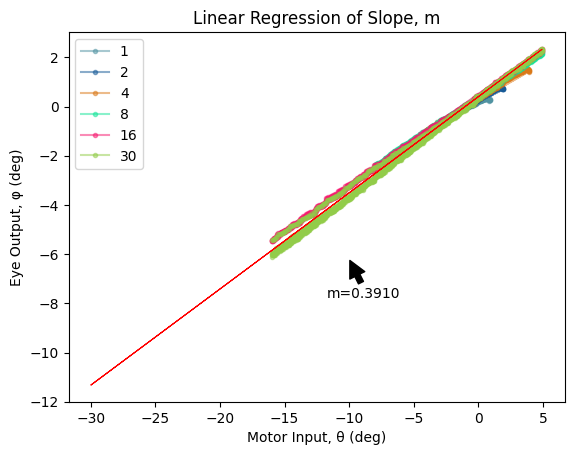

In [31]:
# Plotting

trim_list = [1, 2, 4, 8, 16, 30]
X_arr = []
Y_arr = []
for i in range(len(baseline_data["data"])):
    pos_log = -1
    input_arr = []
    phi = []
    for cnt in range(len(baseline_data["data"][i]["input_arr"])):
        if cnt > (trim_list[i]/0.0896):
            data = baseline_data["data"][i]["input_arr"][cnt]
            if data > -16 and data < 5 and (data-pos_log)<0:
                input_arr.append(data)
                temp = baseline_data["data"][i]["pixel_arr"][tilt_idx][cnt]
                phi.append(px_to_deg_fx(temp[1]-y_org))
            pos_log = data

    X_arr.extend(input_arr)
    Y_arr.extend(phi)
    
    # Eye Output vs Input Array
    plt.plot(input_arr, phi, color=rand_colors[i], marker='.', alpha=0.5)
    
# data points
plt.xlabel('Motor Input, θ (deg)')
plt.ylabel('Eye Output, φ (deg)')
plt.title('Linear Regression of Slope, m')
plt.annotate('m=%.4f' % (base_regression_model.coef_),
            xy=(-10, -6.2), xycoords='data',
            xytext=(10, -20), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')
plt.legend(['1', '2', '4', '8', '16', '30'])

# predicted values
plt.plot(X, y_predicted_baseline, color='r', linewidth=0.7)
plt.show()

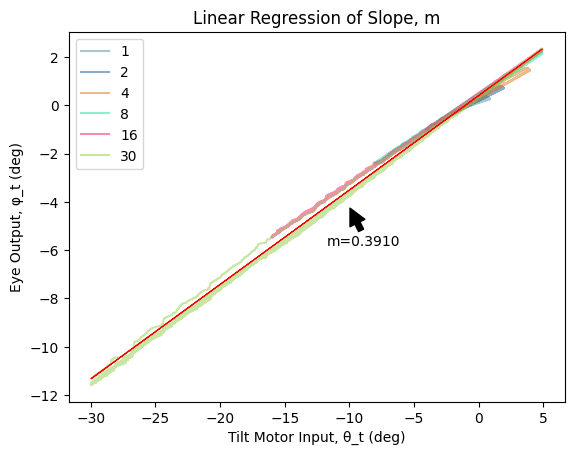

In [32]:
# Line Data Parameters

trim_list = [1, 2, 4, 8, 16, 30]
X_arr = []
Y_arr = []
for i in range(len(baseline_data["data"])):
    pos_log = -1
    input_arr = []
    phi = []
    for cnt in range(len(baseline_data["data"][i]["input_arr"])):
        if cnt > (trim_list[i]/0.0896):
            data = baseline_data["data"][i]["input_arr"][cnt]
            if data > -30 and data < 5 and (data-pos_log)<0:
                input_arr.append(data)
                temp = baseline_data["data"][i]["pixel_arr"][tilt_idx][cnt]
                phi.append(px_to_deg_fx(temp[1]-y_org))
            pos_log = data

    X_arr.extend(input_arr)
    Y_arr.extend(phi)
    
    # Eye Output vs Input Array
    plt.plot(input_arr, phi, color=rand_colors[i], alpha=0.5)
    
X = np.array(X_arr).reshape((-1,1))
Y = np.array(Y_arr)

# data points
plt.xlabel('Tilt Motor Input, θ_t (deg)')
plt.ylabel('Eye Output, φ_t (deg)')
plt.title('Linear Regression of Slope, m')
plt.annotate('m=%.4f' % (base_regression_model.coef_),
            xy=(-10, -4.2), xycoords='data',
            xytext=(10, -20), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')
plt.legend(['1', '2', '4', '8', '16', '30'])

# predicted values
plt.plot(X, y_predicted_baseline, color='r', linewidth=0.7)
plt.show()

In [33]:
X_temp = np.append(X, np.array([-32]).reshape(1, -1))
X_baseline = np.append(X_temp, np.array([6]).reshape(1, -1))
Y_temp = np.append(y_predicted_baseline, np.array([base_regression_model.predict(np.array([-32]).reshape(1, -1))]))
Y_baseline = np.append(Y_temp, np.array([base_regression_model.predict(np.array([6]).reshape(1, -1))]))

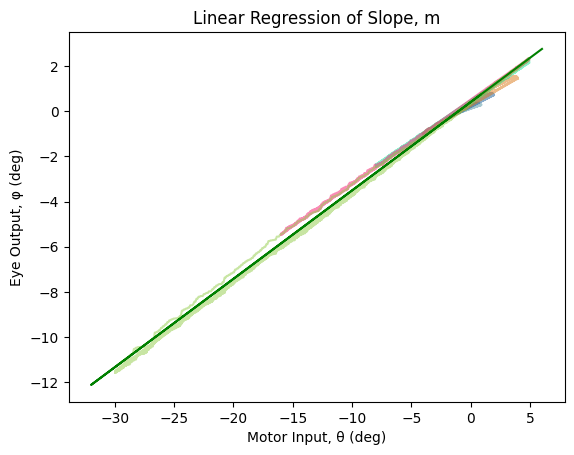

In [34]:
# Line Data Parameters

trim_list = [1, 2, 4, 8, 16, 30]
X_arr = []
Y_arr = []
for i in range(len(baseline_data["data"])):
    pos_log = -1
    input_arr = []
    phi = []
    for cnt in range(len(baseline_data["data"][i]["input_arr"])):
        if cnt > (trim_list[i]/0.0896):
            data = baseline_data["data"][i]["input_arr"][cnt]
            if data > -30 and data < 5 and (data-pos_log)<0:
                input_arr.append(data)
                temp = baseline_data["data"][i]["pixel_arr"][tilt_idx][cnt]
                phi.append(px_to_deg_fx(temp[1]-y_org))
            pos_log = data

    X_arr.extend(input_arr)
    Y_arr.extend(phi)
    
    # Eye Output vs Input Array
    plt.plot(input_arr, phi, color=rand_colors[i], alpha=0.5)

# data points
plt.xlabel('Motor Input, θ (deg)')
plt.ylabel('Eye Output, φ (deg)')
plt.title('Linear Regression of Slope, m')

# predicted values
plt.plot(X_baseline, Y_baseline, color='g')
plt.show()

In [38]:
# Tilt Slope

print(f"Tilt Slope: {base_slope:.4f}")

Tilt Slope: 0.3910
